In [1]:
# !pip install --upgrade git+https://github.com/tooha289/DataAnalysisLibrary.git

In [5]:
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import chi2_contingency
from DataAnalysis import eda

from matplotlib import font_manager

In [6]:
pd.set_option('display.max_rows', 500)

In [7]:
font_path = "C:/Windows/Fonts/malgun.ttf"
font_family = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams["font.family"] = font_family
plt.rcParams["axes.unicode_minus"] = False

In [8]:
# 폴더가 존재하지 않으면 생성
RECALL_PATH = './recalls/'
for path in [RECALL_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"폴더가 생성되었습니다: {path}")
    else:
        print(f"폴더가 이미 존재합니다: {path}")

폴더가 이미 존재합니다: ./recalls/


# 데이터 load

In [10]:
resume = pd.read_csv("../data/resume.csv")
recruitment = pd.read_csv("../data/recruitment.csv")
apply = pd.read_csv("../data/apply_train.csv")

## train_test 분리

In [11]:
train, test = [], []
apply_train_groupby = apply.groupby('resume_seq')['recruitment_seq'].apply(list)
for uid, iids in zip(apply_train_groupby.index.tolist(), apply_train_groupby.values.tolist()):
    for iid in iids[:-1]:
        train.append([uid,iid])
    test.append([uid, iids[-1]])

In [12]:
apply = pd.DataFrame(train, columns=['resume_seq', 'recruitment_seq'])
test = pd.DataFrame(test, columns=['resume_seq', 'recruitment_seq'])

# 전처리

In [13]:
used_cols = ['resume_seq', 'degree', 'job_code_seq1']
resume = resume[used_cols]

used_cols = ['recruitment_seq', 'address_seq1', 'education', 'major_task', 'qualifications']
recruitment = recruitment[used_cols]

## address_seq1의 na값을 0으로 처리

In [14]:
recruitment['address_seq1'].unique()

array([ 3., 20.,  5.,  9., 11.,  1., nan, 13.,  2.])

In [15]:
recruitment = recruitment.fillna({'address_seq1':3}, axis=0)

## 타입 변경

In [16]:
res_categorical_cols = ['degree', 'job_code_seq1']
rec_categorical_cols = ['address_seq1', 'education', 'major_task', 'qualifications']
resume[res_categorical_cols] = resume[res_categorical_cols].astype('category')
recruitment[rec_categorical_cols] = recruitment[rec_categorical_cols].astype('category')

In [17]:
recruitment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   recruitment_seq  6695 non-null   object  
 1   address_seq1     6695 non-null   category
 2   education        6695 non-null   category
 3   major_task       6695 non-null   category
 4   qualifications   6695 non-null   category
dtypes: category(4), object(1)
memory usage: 79.6+ KB


## 데이터 병합

In [18]:
merged_df = resume.merge(apply, how='inner', left_on = 'resume_seq', right_on ='resume_seq')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49464 entries, 0 to 49463
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   resume_seq       49464 non-null  object  
 1   degree           49464 non-null  category
 2   job_code_seq1    49464 non-null  category
 3   recruitment_seq  49464 non-null  object  
dtypes: category(2), object(2)
memory usage: 1.2+ MB


In [19]:
merged_df = merged_df.merge(recruitment, how='inner', left_on = 'recruitment_seq', right_on ='recruitment_seq')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49464 entries, 0 to 49463
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   resume_seq       49464 non-null  object  
 1   degree           49464 non-null  category
 2   job_code_seq1    49464 non-null  category
 3   recruitment_seq  49464 non-null  object  
 4   address_seq1     49464 non-null  category
 5   education        49464 non-null  category
 6   major_task       49464 non-null  category
 7   qualifications   49464 non-null  category
dtypes: category(6), object(2)
memory usage: 1.4+ MB


# EDA

In [20]:
dav = eda.DataAnalysisVisualizer()

## 함수 정의

In [22]:
# eda function
%run ../functions/eda.py
# metric function
%run ../functions/metric.py
# submission function
%run ../functions/submission.py

## degree 분석

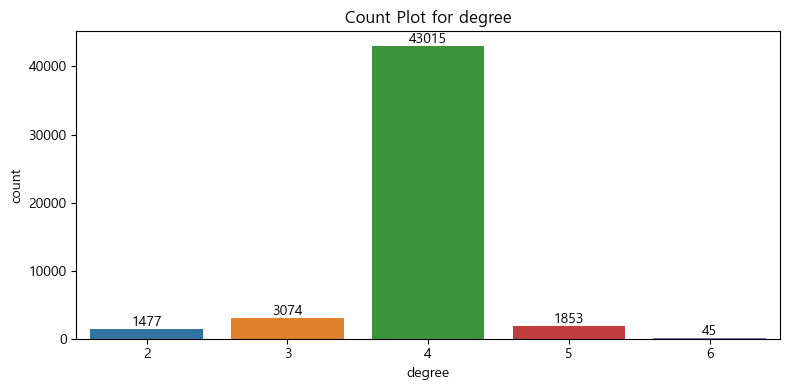

In [23]:
dav.draw_countplot(merged_df, ['degree'], figsize=(8,4))

In [214]:
# 전체 공고의 0.5% = 289.73
limit_ratio = 0.005

### degree : address_seq1

In [215]:
count_df = create_count_dataframe(merged_df, 'address_seq1', 'degree')
ratio_df_hue, ratio_df_hue_ratio = calculate_ratio_df_with_hue(merged_df, 'address_seq1', 'degree', limit_ratio)

In [216]:
count_df

degree,2,3,4,5,6,Total
address_seq1,,,,,,
1.0,3,3,16,0,0,22
2.0,0,2,3,0,0,5
3.0,1440,2972,41768,1796,44,48020
5.0,31,85,1109,49,1,1275
9.0,0,0,8,1,0,9
11.0,0,2,21,1,0,24
13.0,2,1,4,0,0,7
20.0,1,9,86,6,0,102
Total,1477,3074,43015,1853,45,49464


In [217]:
analyze_chi_square(count_df);

Chi-square Statistic: 47.51870400526832
P-value: 0.012067723944160648
Degrees of Freedom: 28
Expected Frequencies:
degree                  2            3             4            5          6
address_seq1                                                                
1.0              0.656922     1.367217     19.131692     0.824155   0.020015
2.0              0.149301     0.310731      4.348112     0.187308   0.004549
3.0           1433.882015  2984.260877  41759.265324  1798.905467  43.686317
5.0             38.071628    79.236414   1108.768498    47.763525   1.159934
9.0              0.268741     0.559316      7.826601     0.337154   0.008188
11.0             0.716642     1.491509     20.870936     0.899078   0.021834
13.0             0.209021     0.435023      6.087356     0.262231   0.006368
20.0             3.045730     6.338913     88.701480     3.821082   0.092795


In [218]:
ratio_df_hue

degree,2,3,4,5,Total
address_seq1,,,,,
3.0,0.974949,0.966818,0.971010,0.969239,0.970807
5.0,0.020988,0.027651,0.025782,0.026444,0.025776
Total,1477.000000,3074.000000,43015.000000,1853.000000,49464.000000


In [219]:
ratio_df_hue_ratio

degree,2,3,4,5,Total
address_seq1,,,,,
3.0,1.004267,0.995891,1.000209,0.998385,0.970807
5.0,0.814255,1.072739,1.000209,1.025887,0.025776
Total,1477.000000,3074.000000,43015.000000,1853.000000,49464.000000


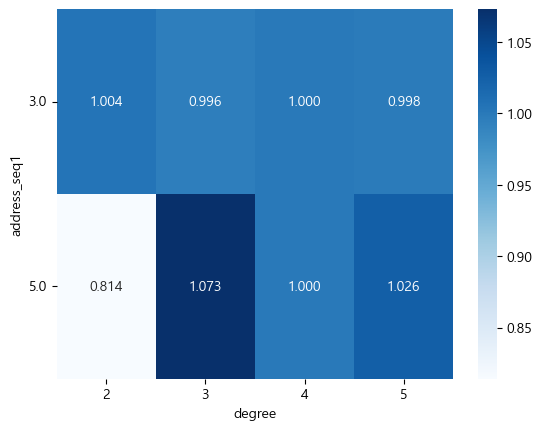

In [220]:
sns.heatmap(ratio_df_hue_ratio.iloc[:-1, :-1], cmap="Blues", annot=True, fmt=".3f")
plt.yticks(rotation=0)  # Adjust the rotation angle here (0 for horizontal, 90 for vertical)
plt.show()

### degree : education

In [221]:
count_df = create_count_dataframe(merged_df, 'education', 'degree')
ratio_df_hue, ratio_df_hue_ratio = calculate_ratio_df_with_hue(merged_df, 'education', 'degree', limit_ratio)

In [222]:
count_df

degree,2,3,4,5,6,Total
education,,,,,,
2,445,890,10876,464,15,12690
3,638,1384,17867,704,16,20609
4,394,799,14264,684,14,16155
6,0,1,8,1,0,10
Total,1477,3074,43015,1853,45,49464


In [223]:
analyze_chi_square(count_df);

Chi-square Statistic: 117.15830456208133
P-value: 2.2748462187102274e-19
Degrees of Freedom: 12
Expected Frequencies:
degree              2            3             4           5          6
education                                                              
2          378.924672   788.635371  11035.507642  475.387555  11.544760
3          615.386807  1280.771187  17922.047044  772.045872  18.749090
4          482.389920  1003.971980  14048.749090  605.191958  14.697052
6            0.298601     0.621462      8.696224    0.374616   0.009098


In [224]:
ratio_df_hue_ratio

degree,2,3,4,5,Total
education,,,,,
2,1.174376,1.128532,0.985546,0.976046,0.256550
3,1.036746,1.080599,0.996929,0.911863,0.416646
4,0.816767,0.795839,1.015322,1.130220,0.326601
Total,1477.000000,3074.000000,43015.000000,1853.000000,49464.000000


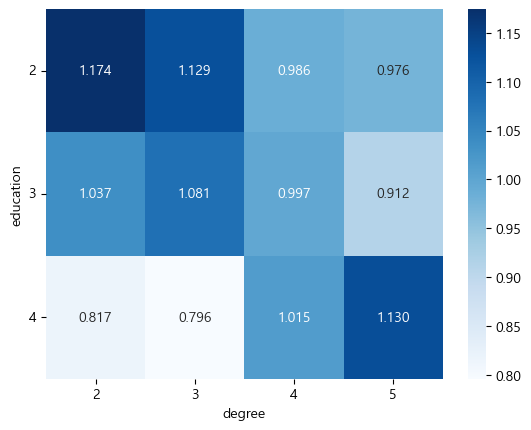

In [225]:
sns.heatmap(ratio_df_hue_ratio.iloc[:-1, :-1], cmap="Blues", annot=True, fmt=".3f")
plt.yticks(rotation=0)  # Adjust the rotation angle here (0 for horizontal, 90 for vertical)
plt.show()

### degree : major_task

In [226]:
count_df = create_count_dataframe(merged_df, 'major_task', 'degree')
ratio_df_hue, ratio_df_hue_ratio = calculate_ratio_df_with_hue(merged_df, 'major_task', 'degree', limit_ratio)

In [227]:
count_df

degree,2,3,4,5,6,Total
major_task,,,,,,
1,6,12,194,6,0,218
2,1432,2935,40766,1768,45,46946
6,0,0,4,0,0,4
7,23,48,583,23,0,677
8,16,79,1443,53,0,1591
9,0,0,13,2,0,15
10,0,0,12,1,0,13
Total,1477,3074,43015,1853,45,49464


In [228]:
analyze_chi_square(count_df);

Chi-square Statistic: 41.30391028693087
P-value: 0.015422234759455773
Degrees of Freedom: 24
Expected Frequencies:
degree                2            3             4            5          6
major_task                                                                
1              6.509502    13.547873    189.577673     8.166626   0.198326
2           1401.812268  2917.515850  40825.290919  1758.671721  42.709243
6              0.119440     0.248585      3.478489     0.149846   0.003639
7             20.215288    42.072982    588.734332    25.361495   0.615902
8             47.507420    98.874616   1383.569161    59.601387   1.447416
9              0.447902     0.932193     13.044335     0.561924   0.013646
10             0.388181     0.807901     11.305091     0.487001   0.011827


In [229]:
ratio_df_hue_ratio

degree,2,3,4,5,Total
major_task,,,,,
2,1.021535,1.005993,0.998548,1.005304,0.949094
7,1.137753,1.140875,0.990260,0.906887,0.013687
8,0.336789,0.798992,1.042955,0.889241,0.032165
Total,1477.000000,3074.000000,43015.000000,1853.000000,49464.000000


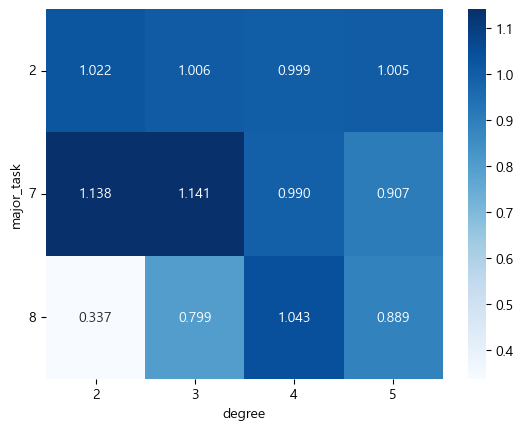

In [230]:
sns.heatmap(ratio_df_hue_ratio.iloc[:-1, :-1], cmap="Blues", annot=True, fmt=".3f")
plt.yticks(rotation=0)  # Adjust the rotation angle here (0 for horizontal, 90 for vertical)
plt.show()

### degree : qualifications

In [231]:
count_df = create_count_dataframe(merged_df, 'qualifications', 'degree')
ratio_df_hue, ratio_df_hue_ratio = calculate_ratio_df_with_hue(merged_df, 'qualifications', 'degree', limit_ratio)

In [232]:
count_df

degree,2,3,4,5,6,Total
qualifications,,,,,,
0,7,23,306,19,1,356
1,1060,2047,28033,1207,31,32378
2,410,1004,14676,627,13,16730
Total,1477,3074,43015,1853,45,49464


In [233]:
analyze_chi_square(count_df);

Chi-square Statistic: 34.0893855367305
P-value: 3.913908760855388e-05
Degrees of Freedom: 8
Expected Frequencies:
degree                   2            3             4            5          6
qualifications                                                               
0                10.630196    22.124050    309.585557    13.336325   0.323872
1               966.810327  2012.169901  28156.632500  1212.931304  29.455968
2               499.559478  1039.706049  14548.781942   626.732371  15.220160


In [234]:
ratio_df_hue_ratio

degree,2,3,4,5,Total
qualifications,,,,,
0,0.658502,1.039593,0.988418,1.424680,0.007197
1,1.096389,1.017310,0.995609,0.995110,0.654577
2,0.820723,0.965658,1.008744,1.000427,0.338226
Total,1477.000000,3074.000000,43015.000000,1853.000000,49464.000000


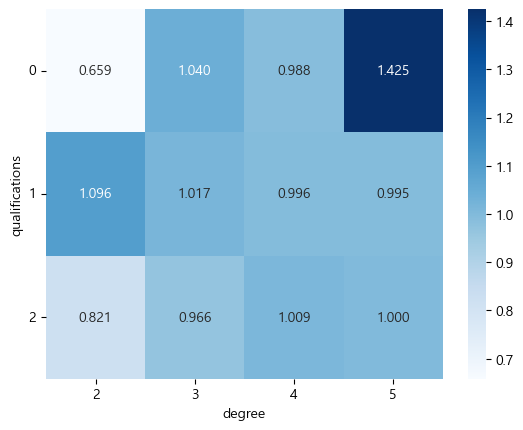

In [235]:
sns.heatmap(ratio_df_hue_ratio.iloc[:-1, :-1], cmap="Blues", annot=True, fmt=".3f")
plt.yticks(rotation=0)  # Adjust the rotation angle here (0 for horizontal, 90 for vertical)
plt.show()

## job_code_seq1 분석

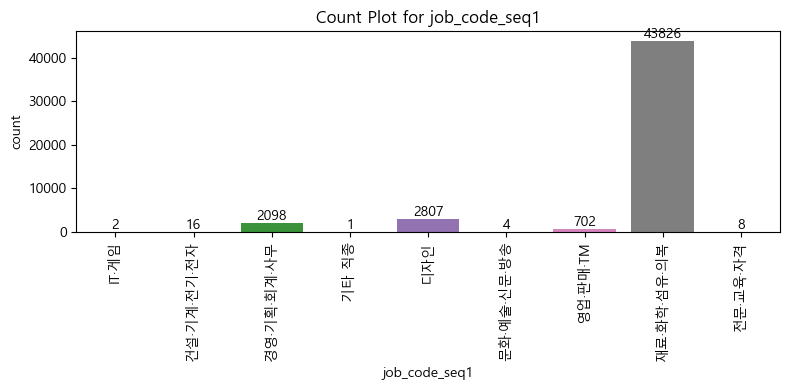

In [46]:
dav.draw_countplot(merged_df, ['job_code_seq1'], figsize=(8,4), rotate_xticks=True)

In [47]:
# 전체 공고의 0.5% = 289.73
limit_ratio = 0.005

### job_code_seq1 : address_seq1

In [186]:
count_df = create_count_dataframe(merged_df, 'address_seq1', 'job_code_seq1')
ratio_df_hue, ratio_df_hue_ratio = calculate_ratio_df_with_hue(merged_df, 'address_seq1', 'job_code_seq1', limit_ratio)

In [187]:
count_df

job_code_seq1,IT·게임,건설·기계·전기·전자,경영·기획·회계·사무,기타 직종,디자인,문화·예술·신문·방송,영업·판매·TM,재료·화학·섬유·의복,전문·교육·자격,Total
address_seq1,,,,,,,,,,
1.0,0,0,0,0,5,0,0,17,0,22
2.0,0,0,0,0,1,0,0,4,0,5
3.0,2,16,2032,0,2680,4,675,42603,8,48020
5.0,0,0,62,1,105,0,24,1083,0,1275
9.0,0,0,0,0,0,0,0,9,0,9
11.0,0,0,0,0,3,0,1,20,0,24
13.0,0,0,0,0,0,0,0,7,0,7
20.0,0,0,4,0,13,0,2,83,0,102
Total,2,16,2098,1,2807,4,702,43826,8,49464


In [188]:
analyze_chi_square(count_df);

Chi-square Statistic: 90.5157146024863
P-value: 0.002387388332248524
Degrees of Freedom: 56
Expected Frequencies:
job_code_seq1     IT·게임  건설·기계·전기·전자  경영·기획·회계·사무     기타 직종          디자인  \
address_seq1                                                               
1.0            0.000890     0.007116     0.933123  0.000445     1.248464   
2.0            0.000202     0.001617     0.212073  0.000101     0.283742   
3.0            1.941614    15.532913  2036.753194  0.970807  2725.055394   
5.0            0.051553     0.412421    54.078724  0.025776    72.354136   
9.0            0.000364     0.002911     0.381732  0.000182     0.510735   
11.0           0.000970     0.007763     1.017952  0.000485     1.361960   
13.0           0.000283     0.002264     0.296903  0.000142     0.397238   
20.0           0.004124     0.032994     4.326298  0.002062     5.788331   

job_code_seq1  문화·예술·신문·방송    영업·판매·TM   재료·화학·섬유·의복  전문·교육·자격  
address_seq1                                                

In [189]:
ratio_df_hue

job_code_seq1,경영·기획·회계·사무,디자인,영업·판매·TM,재료·화학·섬유·의복,Total
address_seq1,,,,,
3.0,0.968541,0.954756,0.961538,0.972094,0.970807
5.0,0.029552,0.037406,0.034188,0.024711,0.025776
Total,2098.000000,2807.000000,702.000000,43826.000000,49464.000000


In [190]:
ratio_df_hue_ratio

job_code_seq1,경영·기획·회계·사무,디자인,영업·판매·TM,재료·화학·섬유·의복,Total
address_seq1,,,,,
3.0,0.997666,0.983466,0.990453,1.001326,0.970807
5.0,1.146477,1.451196,1.326335,0.958684,0.025776
Total,2098.000000,2807.000000,702.000000,43826.000000,49464.000000


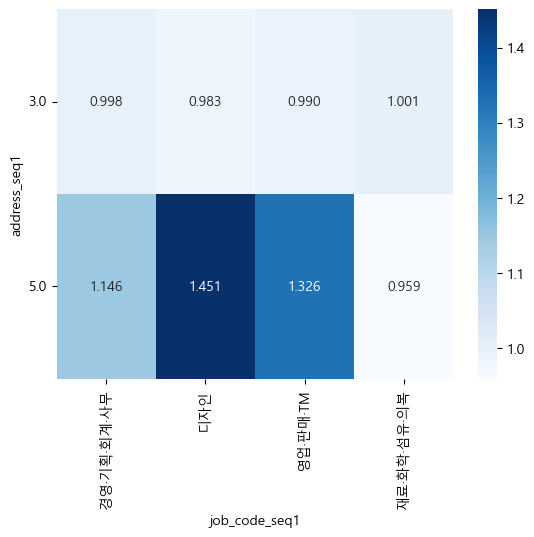

In [191]:
sns.heatmap(ratio_df_hue_ratio.iloc[:-1, :-1], cmap="Blues", annot=True, fmt=".3f")
plt.yticks(rotation=0)  # Adjust the rotation angle here (0 for horizontal, 90 for vertical)
plt.show()

### job_code_seq1 : education

In [54]:
count_df = create_count_dataframe(merged_df, 'education', 'job_code_seq1')
ratio_df_hue, ratio_df_hue_ratio = calculate_ratio_df_with_hue(merged_df, 'education', 'job_code_seq1', limit_ratio)

In [55]:
count_df

job_code_seq1,IT·게임,건설·기계·전기·전자,경영·기획·회계·사무,기타 직종,디자인,문화·예술·신문·방송,영업·판매·TM,재료·화학·섬유·의복,전문·교육·자격,Total
education,,,,,,,,,,
2,0,3,632,0,1002,2,222,10827,2,12690
3,1,4,793,1,985,1,278,18545,1,20609
4,1,9,673,0,817,1,202,14447,5,16155
6,0,0,0,0,3,0,0,7,0,10
Total,2,16,2098,1,2807,4,702,43826,8,49464


In [56]:
analyze_chi_square(count_df);

Chi-square Statistic: 231.89823411526885
P-value: 6.202809451187623e-36
Degrees of Freedom: 24
Expected Frequencies:
job_code_seq1     IT·게임  건설·기계·전기·전자  경영·기획·회계·사무     기타 직종          디자인  \
education                                                                  
2              0.513100     4.104803   538.242358  0.256550   720.136463   
3              0.833293     6.666343   874.124252  0.416646  1169.526585   
4              0.653202     5.225619   685.209243  0.326601   916.769469   
6              0.000404     0.003235     0.424147  0.000202     0.567483   

job_code_seq1  문화·예술·신문·방송    영업·판매·TM   재료·화학·섬유·의복  전문·교육·자격  
education                                                       
2                 1.026201  180.098253  11243.569869  2.052402  
3                 1.666586  292.485808  18259.947315  3.333172  
4                 1.306405  229.274017  14313.622635  2.612809  
6                 0.000809    0.141921      8.860181  0.001617  


In [57]:
ratio_df_hue

job_code_seq1,경영·기획·회계·사무,디자인,영업·판매·TM,재료·화학·섬유·의복,Total
education,,,,,
2,0.301239,0.356965,0.316239,0.247045,0.256550
3,0.377979,0.350908,0.396011,0.423151,0.416646
4,0.320782,0.291058,0.287749,0.329645,0.326601
Total,2098.000000,2807.000000,702.000000,43826.000000,49464.000000


In [58]:
ratio_df_hue_ratio

job_code_seq1,경영·기획·회계·사무,디자인,영업·판매·TM,재료·화학·섬유·의복,Total
education,,,,,
2,1.174192,1.391403,1.232660,0.962950,0.256550
3,0.907194,0.842221,0.950473,1.015611,0.416646
4,0.982182,0.891173,0.881042,1.009318,0.326601
Total,2098.000000,2807.000000,702.000000,43826.000000,49464.000000


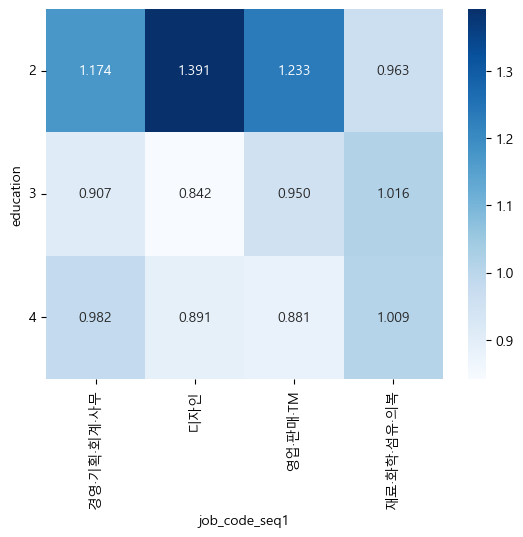

In [59]:
sns.heatmap(ratio_df_hue_ratio.iloc[:-1, :-1], cmap="Blues", annot=True, fmt=".3f")
plt.yticks(rotation=0)  # Adjust the rotation angle here (0 for horizontal, 90 for vertical)
plt.show()

### job_code_seq1 : major_task

In [60]:
count_df = create_count_dataframe(merged_df, 'major_task', 'job_code_seq1')
ratio_df_hue, ratio_df_hue_ratio = calculate_ratio_df_with_hue(merged_df, 'major_task', 'job_code_seq1', limit_ratio)

In [61]:
count_df

job_code_seq1,IT·게임,건설·기계·전기·전자,경영·기획·회계·사무,기타 직종,디자인,문화·예술·신문·방송,영업·판매·TM,재료·화학·섬유·의복,전문·교육·자격,Total
major_task,,,,,,,,,,
1,0,0,14,0,23,0,2,179,0,218
2,2,16,2040,1,2547,3,693,41636,8,46946
6,0,0,0,0,0,0,0,4,0,4
7,0,0,19,0,70,1,4,583,0,677
8,0,0,25,0,166,0,3,1397,0,1591
9,0,0,0,0,1,0,0,14,0,15
10,0,0,0,0,0,0,0,13,0,13
Total,2,16,2098,1,2807,4,702,43826,8,49464


In [62]:
analyze_chi_square(count_df);

Chi-square Statistic: 181.95176066507483
P-value: 1.8070964022204747e-17
Degrees of Freedom: 48
Expected Frequencies:
job_code_seq1     IT·게임  건설·기계·전기·전자  경영·기획·회계·사무     기타 직종          디자인  \
major_task                                                                 
1              0.008814     0.070516     9.246401  0.004407    12.371139   
2              1.898189    15.185509  1991.199822  0.949094  2664.107674   
6              0.000162     0.001294     0.169659  0.000081     0.226993   
7              0.027373     0.218988    28.714742  0.013687    38.418628   
8              0.064330     0.514637    67.481765  0.032165    90.286612   
9              0.000607     0.004852     0.636220  0.000303     0.851225   
10             0.000526     0.004205     0.551391  0.000263     0.737728   

job_code_seq1  문화·예술·신문·방송    영업·판매·TM   재료·화학·섬유·의복  전문·교육·자격  
major_task                                                      
1                 0.017629    3.093886    193.151949  0.035258  
2 

In [63]:
ratio_df_hue_ratio

job_code_seq1,경영·기획·회계·사무,디자인,영업·판매·TM,재료·화학·섬유·의복,Total
major_task,,,,,
2,1.024508,0.956042,1.040128,1.000986,0.949094
7,0.661681,1.822033,0.416316,0.971935,0.013687
8,0.370470,1.838589,0.132863,0.991023,0.032165
Total,2098.000000,2807.000000,702.000000,43826.000000,49464.000000


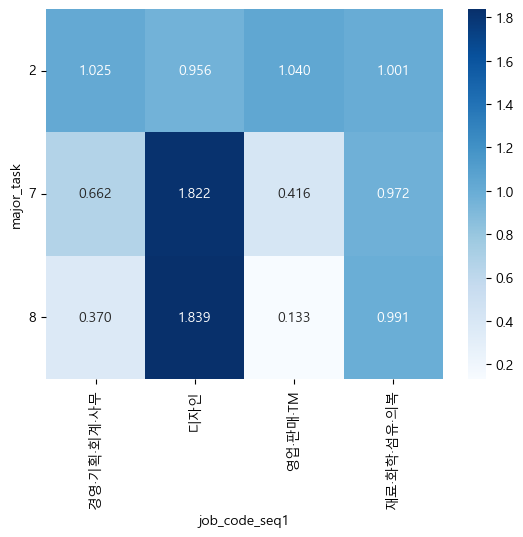

In [64]:
sns.heatmap(ratio_df_hue_ratio.iloc[:-1, :-1], cmap="Blues", annot=True, fmt=".3f")
plt.yticks(rotation=0)  # Adjust the rotation angle here (0 for horizontal, 90 for vertical)
plt.show()

### job_code_seq1 : qualifications

In [65]:
count_df = create_count_dataframe(merged_df, 'qualifications', 'job_code_seq1')
ratio_df_hue, ratio_df_hue_ratio = calculate_ratio_df_with_hue(merged_df, 'qualifications', 'job_code_seq1', limit_ratio)

In [66]:
count_df

job_code_seq1,IT·게임,건설·기계·전기·전자,경영·기획·회계·사무,기타 직종,디자인,문화·예술·신문·방송,영업·판매·TM,재료·화학·섬유·의복,전문·교육·자격,Total
qualifications,,,,,,,,,,
0,0,1,28,0,94,0,3,230,0,356
1,2,9,1296,1,1867,1,496,28699,7,32378
2,0,6,774,0,846,3,203,14897,1,16730
Total,2,16,2098,1,2807,4,702,43826,8,49464


In [67]:
analyze_chi_square(count_df);

Chi-square Statistic: 348.1787102996088
P-value: 2.481101723598269e-64
Degrees of Freedom: 16
Expected Frequencies:
job_code_seq1      IT·게임  건설·기계·전기·전자  경영·기획·회계·사무     기타 직종          디자인  \
qualifications                                                              
0               0.014394     0.115154    15.099628  0.007197    20.202410   
1               1.309154    10.473233  1373.302685  0.654577  1837.397825   
2               0.676452     5.411612   709.597687  0.338226   949.399765   

job_code_seq1   문화·예술·신문·방송    영업·판매·TM   재료·화학·섬유·의복  전문·교육·자격  
qualifications                                                   
0                  0.028789    5.052402    315.422449  0.057577  
1                  2.618308  459.513100  28687.494501  5.236617  
2                  1.352903  237.434498  14823.083050  2.705806  


In [68]:
ratio_df_hue_ratio

job_code_seq1,경영·기획·회계·사무,디자인,영업·판매·TM,재료·화학·섬유·의복,Total
qualifications,,,,,
0,1.854350,4.652910,0.593777,0.729181,0.007197
1,0.943710,1.016111,1.079403,1.000401,0.654577
2,1.090759,0.891089,0.854973,1.004987,0.338226
Total,2098.000000,2807.000000,702.000000,43826.000000,49464.000000


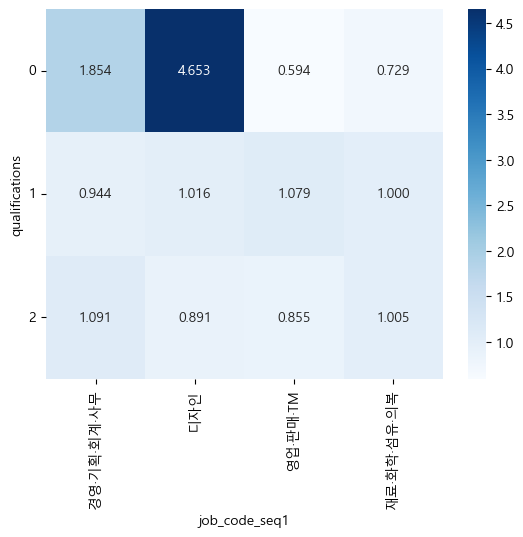

In [69]:
sns.heatmap(ratio_df_hue_ratio.iloc[:-1, :-1], cmap="Blues", annot=True, fmt=".3f")
plt.yticks(rotation=0)  # Adjust the rotation angle here (0 for horizontal, 90 for vertical)
plt.show()

# 인기도 가중치

In [70]:
mms = MinMaxScaler()
stds = StandardScaler()

## degree

### degree별 공고 지원 수

In [71]:
degree_pop = merged_df.groupby(['degree', 'recruitment_seq']).size().to_frame().reset_index()
degree_pop.rename(columns={0:'count'}, inplace=True)
degree_pop = degree_pop.sort_values(['degree', 'count'], ascending=[True,False])

In [72]:
degree_pop['score'] = degree_pop.groupby('degree')['count'].apply(lambda g: g/max(g))

### 단순 인기도 가중치

In [73]:
degree_pop_top5 = degree_pop.groupby('degree').apply(lambda g: g.nlargest(5, 'count')).reset_index(drop=True)

In [74]:
sbm_pop_only = resume[['resume_seq', 'degree']].merge(degree_pop_top5[['recruitment_seq', 'degree']],
                                       how='inner', on='degree')
sbm_pop_only = sbm_pop_only.drop('degree', axis=1)
sbm_pop_only.head()

,resume_seq,recruitment_seq
0,U00606,R01214
1,U00606,R03237
2,U00606,R00056
3,U00606,R04066
4,U00606,R04200


In [75]:
calculate_precision_at_k(test, sbm_pop_only, 5)

0.0010139118132515919

In [76]:
recall5_dacon(test, sbm_pop_only)

0.005069559066257958

### 비율 가중치

In [77]:
degree_pop = degree_pop.merge(recruitment, how='inner', on='recruitment_seq')
degree_pop.head()

,degree,recruitment_seq,count,score,address_seq1,education,major_task,qualifications
0,2,R04150,4,1.000000,3.0,3,2,1
1,3,R04150,0,0.000000,3.0,3,2,1
2,4,R04150,6,0.107143,3.0,3,2,1
3,5,R04150,1,0.166667,3.0,3,2,1
4,6,R04150,0,0.000000,3.0,3,2,1


#### recruitment_feature : degree 가중치

In [236]:
def create_weight_df(origin_df, popularity_df, target_cols, grouping_col, limit_ratio=0.005):
    merged_df = popularity_df.copy()
    weight_dfs = []
    for target_col in target_cols:
        _, ratio_df_hue_ratio = calculate_ratio_df_with_hue(origin_df, target_col, grouping_col, limit_ratio)

        weight_df = ratio_df_hue_ratio.iloc[:-1, :-1].reset_index()
        weight_df = weight_df.melt(id_vars=target_col, var_name=grouping_col, value_name=f'{target_col}_weight')
        weight_dfs.append(weight_df)
        
        merged_df = merged_df.merge(weight_df, how='inner', on=[grouping_col, target_col])
    return merged_df, weight_dfs

In [237]:
degree_weight_pop, weight_dfs = create_weight_df(merged_df, degree_pop, ['address_seq1', 'education',
                                                      'major_task', 'qualifications'], 'degree', limit_ratio=0.05)

In [238]:
degree_weight_pop_columns = degree_weight_pop.filter(like='_weight').columns
degree_weight_pop['multiplied_weight'] = degree_weight_pop.loc[:, degree_weight_pop_columns].prod(axis=1)
degree_weight_pop['w_score'] = degree_weight_pop.loc[:, ['score', 'multiplied_weight']].prod(axis=1)

In [239]:
degree_pop_top5 = degree_weight_pop.groupby('degree').apply(lambda g: g.nlargest(5, 'w_score')).reset_index(drop=True)

In [240]:
sbm_pop = resume[['resume_seq', 'degree']].merge(degree_pop_top5[['recruitment_seq', 'degree']],
                                       how='inner', on='degree')
sbm_pop = sbm_pop.drop('degree', axis=1)
sbm_pop.head()

,resume_seq,recruitment_seq
0,U00606,R01214
1,U00606,R03237
2,U00606,R00056
3,U00606,R04066
4,U00606,R04200


In [242]:
calculate_precision_at_k(test, sbm_pop, 5)

0.0010611419909044974

In [243]:
recall5_dacon(test, sbm_pop)

0.005305709954522486

## job_code_seq1

### job_code_seq1별 공고 지원 수

In [85]:
job_code_pop = merged_df.groupby(['job_code_seq1', 'recruitment_seq']).size().to_frame().reset_index()
job_code_pop.rename(columns={0:'count'}, inplace=True)
job_code_pop = job_code_pop.sort_values(['job_code_seq1', 'count'], ascending=[True,False])

In [86]:
job_code_pop['score'] = job_code_pop.groupby('job_code_seq1')['count'].apply(lambda g: g/max(g))

### 단순 인기도 가중치

In [87]:
job_code_pop_top5 = job_code_pop.groupby('job_code_seq1').apply(lambda g: g.nlargest(5, 'count')).reset_index(drop=True)

In [88]:
sbm_pop_only = resume[['resume_seq', 'job_code_seq1']].merge(job_code_pop_top5[['recruitment_seq', 'job_code_seq1']],
                                       how='inner', on='job_code_seq1')
sbm_pop_only = sbm_pop_only.drop('job_code_seq1', axis=1)
sbm_pop_only.head()

,resume_seq,recruitment_seq
0,U00606,R00773
1,U00606,R04066
2,U00606,R00056
3,U00606,R00559
4,U00606,R03237


In [89]:
calculate_precision_at_k(test, sbm_pop_only, 5)

0.0012261259136995986

In [90]:
recall5_dacon(test, sbm_pop_only)

0.0061306295684979955

### 비율 가중치

In [91]:
job_code_pop = job_code_pop.merge(recruitment, how='inner', on='recruitment_seq')
job_code_pop.head()

,job_code_seq1,recruitment_seq,count,score,address_seq1,education,major_task,qualifications
0,IT·게임,R03890,1,1.0,3.0,3,2,1
1,건설·기계·전기·전자,R03890,0,0.0,3.0,3,2,1
2,경영·기획·회계·사무,R03890,0,0.0,3.0,3,2,1
3,기타 직종,R03890,0,0.0,3.0,3,2,1
4,디자인,R03890,0,0.0,3.0,3,2,1


#### recruitment_feature : job_code_seq1 가중치

In [271]:
job_code_weight_pop, weight_dfs = create_weight_df(merged_df, job_code_pop, ['address_seq1', 'education',
                                                      'major_task', 'qualifications'], 'job_code_seq1', limit_ratio=0.05)

In [272]:
job_code_weight_pop_columns = job_code_weight_pop.filter(like='_weight').columns
job_code_weight_pop['multiplied_weight'] = job_code_weight_pop.loc[:, job_code_weight_pop_columns].prod(axis=1)
job_code_weight_pop['w_score'] = job_code_weight_pop.loc[:, ['score', 'multiplied_weight']].prod(axis=1)

In [273]:
job_code_weight_pop_top5 = job_code_weight_pop.groupby('job_code_seq1').apply(lambda g: g.nlargest(5, 'w_score')).reset_index(drop=True)

In [274]:
sbm_pop = resume[['resume_seq', 'job_code_seq1']].merge(job_code_weight_pop_top5[['recruitment_seq', 'job_code_seq1']],
                                       how='inner', on='job_code_seq1')
sbm_pop = sbm_pop.drop('job_code_seq1', axis=1)
sbm_pop.head()

,resume_seq,recruitment_seq
0,U00606,R00773
1,U00606,R04066
2,U00606,R00056
3,U00606,R05574
4,U00606,R00559


In [262]:
calculate_precision_at_k(test, sbm_pop, 5)

0.0012014314928425356

In [263]:
recall5_dacon(test, sbm_pop)

0.006007157464212679

# 모델 결과 생성

## idx 디코딩

### 디코딩 딕셔너리 로드

In [101]:
DATA_PATH = '../data/'

In [102]:
resume_decode = pd.read_csv(f"{DATA_PATH}idx_2_resume.txt", delimiter=" ", header=None)
resume_decode = resume_decode.set_index(0).to_dict()[1]

In [103]:
recruitment_decode = pd.read_csv(f"{DATA_PATH}/idx_2_recruitment.txt", delimiter=" ", header=None)
recruitment_decode = recruitment_decode.set_index(0).to_dict()[1]

## CF 모델

In [104]:
DATA_SET = "JOB_1"

In [107]:
CF_FOLDER_PATH = '../CF/results/'
cf_proba = pd.read_csv(f'{CF_FOLDER_PATH}pred_prob_{DATA_SET}.txt', delimiter=' ', header=None)
cf_rating_idx = pd.read_csv(f'{CF_FOLDER_PATH}pred_idx_{DATA_SET}.txt', delimiter=' ', header=None)

In [108]:
cf_score = create_score_dataframe(cf_proba, cf_rating_idx, "cf")
cf_score.head(20)

,resume_idx,recruitment_idx,cf_score
0,0,156,1.000000
1,0,4670,0.744136
2,0,3349,0.674452
3,0,2576,0.649263
4,0,4675,0.578998
5,0,5450,0.552090
6,0,5164,0.529899
7,0,5097,0.505583
8,0,2756,0.482113
9,0,6228,0.477240


In [109]:
sbm_cf = create_submission(cf_rating_idx, resume_decode, recruitment_decode)

In [110]:
recall5_dacon(test, sbm_cf)

0.12827163404857345

## LTOCF 모델

In [111]:
LTOCF_FOLDER_PATH = '../LT-OCF/results/'
LTOCF_FILE_NAME = 'JOB_1_360_0.0031__319_0.3145'

In [112]:
lt_proba = pd.read_csv(f'{LTOCF_FOLDER_PATH}proba_{LTOCF_FILE_NAME}.txt', delimiter=' ', header=None)
lt_rating_idx= pd.read_csv(f'{LTOCF_FOLDER_PATH}rating_{LTOCF_FILE_NAME}.txt', delimiter=' ', header=None)
lt_user = pd.read_csv(f'{LTOCF_FOLDER_PATH}user_{LTOCF_FILE_NAME}.txt', delimiter=' ', header=None)

In [113]:
lt_proba_df = pd.concat([lt_user, lt_proba], axis=1)
lt_idx_df = pd.concat([lt_user, lt_rating_idx], axis=1)

In [114]:
ltocf_score = create_score_dataframe(lt_proba_df, lt_idx_df, "ltocf")
ltocf_score.head()

,resume_idx,recruitment_idx,ltocf_score
0,0,156,0.999877
1,0,3195,0.999227
2,0,1051,0.998012
3,0,4670,0.997515
4,0,2576,0.997507


In [128]:
lt_idx_df.columns = range(lt_idx_df.shape[1])

In [129]:
sbm_ltocf = create_submission(lt_idx_df, resume_decode, recruitment_decode)

In [171]:
sbm_ltocf.sort_values("resume_seq")

,resume_seq,recruitment_seq
25778,U00001,R03777
332,U00001,R01528
8814,U00001,R03811
34260,U00001,R02064
17296,U00001,R02400
...,...,...
41920,U08482,R02524
16474,U08482,R00712
24956,U08482,R01186
7992,U08482,R04602


In [130]:
recall5_dacon(test, sbm_ltocf)

0.12968639471822682

# 모델 결과 + 인기도 가중치

## CF 인기도 가중치 적용

In [248]:
cf_score['resume_seq'] = cf_score['resume_idx'].apply(lambda x: resume_decode[x])
cf_score['recruitment_seq'] = cf_score['recruitment_idx'].apply(lambda x: recruitment_decode[x])
cf_score.head()

,resume_idx,recruitment_idx,cf_score,resume_seq,recruitment_seq
0,0,156,1.000000,U05833,R03943
1,0,4670,0.744136,U05833,R04100
2,0,3349,0.674452,U05833,R00353
3,0,2576,0.649263,U05833,R00097
4,0,4675,0.578998,U05833,R02806


In [249]:
cf_score = cf_score.merge(resume, how='inner', on='resume_seq')
cf_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169640 entries, 0 to 169639
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   resume_idx       169640 non-null  int64   
 1   recruitment_idx  169640 non-null  int64   
 2   cf_score         169640 non-null  float64 
 3   resume_seq       169640 non-null  object  
 4   recruitment_seq  169640 non-null  object  
 5   degree           169640 non-null  category
 6   job_code_seq1    169640 non-null  category
dtypes: category(2), float64(1), int64(2), object(2)
memory usage: 8.1+ MB


### Degree

In [250]:
degree_weight_pop_view = degree_weight_pop[['degree', 'recruitment_seq',
                                            'score', 'w_score']]

In [251]:
cf_score_pop = cf_score.merge(degree_weight_pop_view, how='left', on=['degree', 'recruitment_seq'])
cf_score_pop[['score', 'w_score']] = cf_score_pop[['score', 'w_score']].fillna(0)
cf_score_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169640 entries, 0 to 169639
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   resume_idx       169640 non-null  int64   
 1   recruitment_idx  169640 non-null  int64   
 2   cf_score         169640 non-null  float64 
 3   resume_seq       169640 non-null  object  
 4   recruitment_seq  169640 non-null  object  
 5   degree           169640 non-null  int64   
 6   job_code_seq1    169640 non-null  category
 7   score            169640 non-null  float64 
 8   w_score          169640 non-null  float64 
dtypes: category(1), float64(3), int64(3), object(2)
memory usage: 11.8+ MB


#### MinMax Scaling

In [252]:
# cf_score_pop['w_score'] = mms.fit_transform(cf_score_pop['w_score'].values.reshape(-1,1))
# cf_score_pop['cf_score'] = mms.fit_transform(cf_score_pop['cf_score'].values.reshape(-1,1))

In [253]:
cf_score_pop['s_score'] = cf_score_pop.groupby('resume_idx')['score'].transform(
    lambda x: (mms.fit_transform(x.values.reshape(-1,1))).reshape(-1))
cf_score_pop['sw_score'] = cf_score_pop.groupby('resume_idx')['w_score'].transform(
    lambda x: (mms.fit_transform(x.values.reshape(-1,1))).reshape(-1))
cf_score_pop['scf_score'] = cf_score_pop.groupby('resume_idx')['cf_score'].transform(
    lambda x: (mms.fit_transform(x.values.reshape(-1,1))).reshape(-1))

#### RECALL 계산

##### 단순인기도

In [112]:
recalls_1 = []

In [114]:
pop_scores = create_ensemble_submission_2col(cf_score_pop, 'scf_score', 's_score', start=0, end=101, step=10)

0.00 : 1.00
0.10 : 0.90
0.20 : 0.80
0.30 : 0.70
0.40 : 0.60
0.50 : 0.50
0.60 : 0.40
0.70 : 0.30
0.80 : 0.20
0.90 : 0.10
1.00 : 0.00


In [115]:
for ratio, sbm in tqdm(pop_scores.items()):
    data = {}
    data['ratio'] = ratio
    data['recall'] = calculate_precision_at_k_dacon(test, sbm, 5)
    recalls_1.append(data)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:13<00:00,  1.19s/it]


In [116]:
pd.DataFrame(recalls_1).drop_duplicates().sort_values('recall', ascending=False)

,ratio,recall
10,1.00:0.00,0.128272
8,0.80:0.20,0.127328
9,0.90:0.10,0.127328
7,0.70:0.30,0.125914
6,0.60:0.40,0.121905
5,0.50:0.50,0.116954
4,0.40:0.60,0.110705
3,0.30:0.70,0.103160
2,0.20:0.80,0.098208
1,0.10:0.90,0.092077


##### 가중치 인기도

In [254]:
recalls_2 = []

In [255]:
pop_scores = create_ensemble_submission_2col(cf_score_pop, 'scf_score', 'sw_score', start=0, end=101, step=10)

0.00 : 1.00
0.10 : 0.90
0.20 : 0.80
0.30 : 0.70
0.40 : 0.60
0.50 : 0.50
0.60 : 0.40
0.70 : 0.30
0.80 : 0.20
0.90 : 0.10
1.00 : 0.00


In [256]:
for ratio, sbm in tqdm(pop_scores.items()):
    data = {}
    data['ratio'] = ratio
    data['recall'] = calculate_precision_at_k_dacon(test, sbm, 5)
    recalls_2.append(data)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:13<00:00,  1.22s/it]


In [257]:
pd.DataFrame(recalls_2).drop_duplicates().sort_values('recall', ascending=False)

,ratio,recall
10,1.00:0.00,0.128272
9,0.90:0.10,0.126975
8,0.80:0.20,0.126857
7,0.70:0.30,0.125324
6,0.60:0.40,0.121669
5,0.50:0.50,0.116836
4,0.40:0.60,0.110587
3,0.30:0.70,0.105635
2,0.20:0.80,0.100094
1,0.10:0.90,0.094082


### job_code_seq1

In [275]:
job_code_weight_pop_view = job_code_weight_pop[['job_code_seq1', 'recruitment_seq',
                                            'score', 'w_score']]

In [276]:
cf_score_pop = cf_score.merge(job_code_weight_pop_view, how='left', on=['job_code_seq1', 'recruitment_seq'])
cf_score_pop[['score', 'w_score']] = cf_score_pop[['score', 'w_score']].fillna(0)
cf_score_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169640 entries, 0 to 169639
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   resume_idx       169640 non-null  int64   
 1   recruitment_idx  169640 non-null  int64   
 2   cf_score         169640 non-null  float64 
 3   resume_seq       169640 non-null  object  
 4   recruitment_seq  169640 non-null  object  
 5   degree           169640 non-null  category
 6   job_code_seq1    169640 non-null  object  
 7   score            169640 non-null  float64 
 8   w_score          169640 non-null  float64 
dtypes: category(1), float64(3), int64(2), object(3)
memory usage: 11.8+ MB


#### MinMax Scaling

In [277]:
# cf_score_pop['w_score'] = mms.fit_transform(cf_score_pop['w_score'].values.reshape(-1,1))
# cf_score_pop['cf_score'] = mms.fit_transform(cf_score_pop['cf_score'].values.reshape(-1,1))

In [278]:
cf_score_pop['s_score'] = cf_score_pop.groupby('resume_idx')['score'].transform(
    lambda x: (mms.fit_transform(x.values.reshape(-1,1))).reshape(-1))
cf_score_pop['sw_score'] = cf_score_pop.groupby('resume_idx')['w_score'].transform(
    lambda x: (mms.fit_transform(x.values.reshape(-1,1))).reshape(-1))
cf_score_pop['scf_score'] = cf_score_pop.groupby('resume_idx')['cf_score'].transform(
    lambda x: (mms.fit_transform(x.values.reshape(-1,1))).reshape(-1))

In [279]:
cf_score_pop.describe(include ='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
resume_idx,169640.0,NaN,NaN,NaN,4240.5,2448.549692,0.0,2120.0,4240.5,6361.0,8481.0
recruitment_idx,169640.0,NaN,NaN,NaN,2903.618586,1892.670689,0.0,1241.0,2685.0,4446.0,6694.0
cf_score,169640.0,NaN,NaN,NaN,0.59639,0.194204,0.022234,0.46132,0.57609,0.714961,1.0
resume_seq,169640,8482,U05833,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recruitment_seq,169640,6684,R03237,422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
degree,169640.0,5.0,4.0,149060.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_code_seq1,169640,9,재료·화학·섬유·의복,145760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,169640.0,NaN,NaN,NaN,0.176694,0.155796,0.0,0.069767,0.139535,0.232558,1.0
w_score,169640.0,NaN,NaN,NaN,0.177559,0.157599,0.0,0.072997,0.142749,0.23683,1.165764
s_score,169640.0,NaN,NaN,NaN,0.340865,0.284522,0.0,0.111111,0.3,0.5,1.0


#### RECALL 계산

##### 단순인기도

In [126]:
recalls_1 = []

In [127]:
pop_scores = create_ensemble_submission_2col(cf_score_pop, 'scf_score', 's_score', start=0, end=101, step=1)

0.00 : 1.00
0.01 : 0.99
0.02 : 0.98
0.03 : 0.97
0.04 : 0.96
0.05 : 0.95
0.06 : 0.94
0.07 : 0.93
0.08 : 0.92
0.09 : 0.91
0.10 : 0.90
0.11 : 0.89
0.12 : 0.88
0.13 : 0.87
0.14 : 0.86
0.15 : 0.85
0.16 : 0.84
0.17 : 0.83
0.18 : 0.82
0.19 : 0.81
0.20 : 0.80
0.21 : 0.79
0.22 : 0.78
0.23 : 0.77
0.24 : 0.76
0.25 : 0.75
0.26 : 0.74
0.27 : 0.73
0.28 : 0.72
0.29 : 0.71
0.30 : 0.70
0.31 : 0.69
0.32 : 0.68
0.33 : 0.67
0.34 : 0.66
0.35 : 0.65
0.36 : 0.64
0.37 : 0.63
0.38 : 0.62
0.39 : 0.61
0.40 : 0.60
0.41 : 0.59
0.42 : 0.58
0.43 : 0.57
0.44 : 0.56
0.45 : 0.55
0.46 : 0.54
0.47 : 0.53
0.48 : 0.52
0.49 : 0.51
0.50 : 0.50
0.51 : 0.49
0.52 : 0.48
0.53 : 0.47
0.54 : 0.46
0.55 : 0.45
0.56 : 0.44
0.57 : 0.43
0.58 : 0.42
0.59 : 0.41
0.60 : 0.40
0.61 : 0.39
0.62 : 0.38
0.63 : 0.37
0.64 : 0.36
0.65 : 0.35
0.66 : 0.34
0.67 : 0.33
0.68 : 0.32
0.69 : 0.31
0.70 : 0.30
0.71 : 0.29
0.72 : 0.28
0.73 : 0.27
0.74 : 0.26
0.75 : 0.25
0.76 : 0.24
0.77 : 0.23
0.78 : 0.22
0.79 : 0.21
0.80 : 0.20
0.81 : 0.19
0.82 : 0.18
0.83

In [128]:
for ratio, sbm in tqdm(pop_scores.items()):
    data = {}
    data['ratio'] = ratio
    data['recall'] = calculate_precision_at_k_dacon(test, sbm, 5)
    recalls_1.append(data)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:57<00:00,  1.16s/it]


In [135]:
recall_job_1 = pd.DataFrame(recalls_1).drop_duplicates().sort_values('recall', ascending=False)
recall_job_1.head()

,ratio,recall
82,0.82:0.18,0.128979
94,0.94:0.06,0.128861
88,0.88:0.12,0.128861
85,0.85:0.15,0.128743
93,0.93:0.07,0.128743


In [139]:
recall_job_1.to_csv(f'{RECALL_PATH}/simple_{DATA_SET}.csv', index=False)

##### 가중치 인기도

In [280]:
recalls_2 = []

In [282]:
pop_scores = create_ensemble_submission_2col(cf_score_pop, 'scf_score', 'sw_score', start=0, end=101, step=10)

0.00 : 1.00
0.10 : 0.90
0.20 : 0.80
0.30 : 0.70
0.40 : 0.60
0.50 : 0.50
0.60 : 0.40
0.70 : 0.30
0.80 : 0.20
0.90 : 0.10
1.00 : 0.00


In [283]:
for ratio, sbm in tqdm(pop_scores.items()):
    data = {}
    data['ratio'] = ratio
    data['recall'] = calculate_precision_at_k_dacon(test, sbm, 5)
    recalls_2.append(data)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.18s/it]


In [284]:
recall_job_2 = pd.DataFrame(recalls_2).drop_duplicates().sort_values('recall', ascending=False)
recall_job_2.head()

,ratio,recall
10,1.00:0.00,0.128272
8,0.80:0.20,0.127682
9,0.90:0.10,0.127682
7,0.70:0.30,0.125560
6,0.60:0.40,0.121669


In [141]:
recall_job_2.to_csv(f'{RECALL_PATH}/weighted_{DATA_SET}.csv', index=False)

## LTOCF 인기도 가중치 적용

In [156]:
MODEL = "LTOCF"

In [134]:
ltocf_score['resume_seq'] = ltocf_score['resume_idx'].apply(lambda x: resume_decode[x])
ltocf_score['recruitment_seq'] = ltocf_score['recruitment_idx'].apply(lambda x: recruitment_decode[x])
ltocf_score.head()

,resume_idx,recruitment_idx,ltocf_score,resume_seq,recruitment_seq
0,0,156,0.999877,U05833,R03943
1,0,3195,0.999227,U05833,R05806
2,0,1051,0.998012,U05833,R02540
3,0,4670,0.997515,U05833,R04100
4,0,2576,0.997507,U05833,R00097


In [135]:
ltocf_score = ltocf_score.merge(resume, how='inner', on='resume_seq')
ltocf_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169640 entries, 0 to 169639
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   resume_idx       169640 non-null  int64   
 1   recruitment_idx  169640 non-null  int64   
 2   ltocf_score      169640 non-null  float64 
 3   resume_seq       169640 non-null  object  
 4   recruitment_seq  169640 non-null  object  
 5   degree           169640 non-null  category
 6   job_code_seq1    169640 non-null  category
dtypes: category(2), float64(1), int64(2), object(2)
memory usage: 8.1+ MB


### Degree

In [136]:
degree_weight_pop_view = degree_weight_pop[['degree', 'recruitment_seq',
                                            'score', 'w_score']]

In [137]:
ltocf_score_pop = ltocf_score.merge(degree_weight_pop_view, how='left', on=['degree', 'recruitment_seq'])
ltocf_score_pop[['score', 'w_score']] = ltocf_score_pop[['score', 'w_score']].fillna(0)
ltocf_score_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169640 entries, 0 to 169639
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   resume_idx       169640 non-null  int64   
 1   recruitment_idx  169640 non-null  int64   
 2   ltocf_score      169640 non-null  float64 
 3   resume_seq       169640 non-null  object  
 4   recruitment_seq  169640 non-null  object  
 5   degree           169640 non-null  int64   
 6   job_code_seq1    169640 non-null  category
 7   score            169640 non-null  float64 
 8   w_score          169640 non-null  float64 
dtypes: category(1), float64(3), int64(3), object(2)
memory usage: 11.8+ MB


#### MinMax Scaling

In [138]:
# ltocf_score_pop['w_score'] = mms.fit_transform(ltocf_score_pop['w_score'].values.reshape(-1,1))
# ltocf_score_pop['ltocf_score'] = mms.fit_transform(ltocf_score_pop['ltocf_score'].values.reshape(-1,1))

In [139]:
ltocf_score_pop['s_score'] = ltocf_score_pop.groupby('resume_idx')['score'].transform(
    lambda x: (mms.fit_transform(x.values.reshape(-1,1))).reshape(-1))
ltocf_score_pop['sw_score'] = ltocf_score_pop.groupby('resume_idx')['w_score'].transform(
    lambda x: (mms.fit_transform(x.values.reshape(-1,1))).reshape(-1))
ltocf_score_pop['scf_score'] = ltocf_score_pop.groupby('resume_idx')['ltocf_score'].transform(
    lambda x: (mms.fit_transform(x.values.reshape(-1,1))).reshape(-1))

#### RECALL 계산

##### 단순인기도

In [140]:
recalls_1 = []

In [141]:
pop_scores = create_ensemble_submission_2col(ltocf_score_pop, 'scf_score', 's_score', start=0, end=101, step=10)

0.00 : 1.00
0.10 : 0.90
0.20 : 0.80
0.30 : 0.70
0.40 : 0.60
0.50 : 0.50
0.60 : 0.40
0.70 : 0.30
0.80 : 0.20
0.90 : 0.10
1.00 : 0.00


In [142]:
for ratio, sbm in tqdm(pop_scores.items()):
    data = {}
    data['ratio'] = ratio
    data['recall'] = calculate_precision_at_k_dacon(test, sbm, 5)
    recalls_1.append(data)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:13<00:00,  1.23s/it]


In [143]:
pd.DataFrame(recalls_1).drop_duplicates().sort_values('recall', ascending=False)

,ratio,recall
10,1.00:0.00,0.129686
8,0.80:0.20,0.129215
9,0.90:0.10,0.128154
7,0.70:0.30,0.124617
6,0.60:0.40,0.120137
5,0.50:0.50,0.116482
4,0.40:0.60,0.113417
3,0.30:0.70,0.108229
2,0.20:0.80,0.100094
1,0.10:0.90,0.093964


##### 가중치 인기도

In [144]:
recalls_2 = []

In [145]:
pop_scores = create_ensemble_submission_2col(ltocf_score_pop, 'scf_score', 'sw_score', start=0, end=101, step=10)

0.00 : 1.00
0.10 : 0.90
0.20 : 0.80
0.30 : 0.70
0.40 : 0.60
0.50 : 0.50
0.60 : 0.40
0.70 : 0.30
0.80 : 0.20
0.90 : 0.10
1.00 : 0.00


In [146]:
for ratio, sbm in tqdm(pop_scores.items()):
    data = {}
    data['ratio'] = ratio
    data['recall'] = calculate_precision_at_k_dacon(test, sbm, 5)
    recalls_2.append(data)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.16s/it]


In [147]:
pd.DataFrame(recalls_2).drop_duplicates().sort_values('recall', ascending=False)

,ratio,recall
10,1.00:0.00,0.129686
8,0.80:0.20,0.128861
9,0.90:0.10,0.128036
7,0.70:0.30,0.125442
6,0.60:0.40,0.121080
5,0.50:0.50,0.117779
4,0.40:0.60,0.115421
3,0.30:0.70,0.108819
2,0.20:0.80,0.101627
1,0.10:0.90,0.095732


### job_code_seq1

In [175]:
job_code_weight_pop_view = job_code_weight_pop[['job_code_seq1', 'recruitment_seq',
                                            'score', 'w_score']]

In [176]:
ltocf_score_pop = ltocf_score.merge(job_code_weight_pop_view, how='left', on=['job_code_seq1', 'recruitment_seq'])
ltocf_score_pop[['score', 'w_score']] = ltocf_score_pop[['score', 'w_score']].fillna(0)
ltocf_score_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169640 entries, 0 to 169639
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   resume_idx       169640 non-null  int64   
 1   recruitment_idx  169640 non-null  int64   
 2   ltocf_score      169640 non-null  float64 
 3   resume_seq       169640 non-null  object  
 4   recruitment_seq  169640 non-null  object  
 5   degree           169640 non-null  category
 6   job_code_seq1    169640 non-null  object  
 7   score            169640 non-null  float64 
 8   w_score          169640 non-null  float64 
dtypes: category(1), float64(3), int64(2), object(3)
memory usage: 11.8+ MB


#### MinMax Scaling

In [177]:
# ltocf_score_pop['sw_score'] = mms.fit_transform(ltocf_score_pop['w_score'].values.reshape(-1,1))
# ltocf_score_pop['scf_score'] = mms.fit_transform(ltocf_score_pop['ltocf_score'].values.reshape(-1,1))

In [151]:
ltocf_score_pop['s_score'] = ltocf_score_pop.groupby('resume_idx')['score'].transform(
    lambda x: (mms.fit_transform(x.values.reshape(-1,1))).reshape(-1))
ltocf_score_pop['sw_score'] = ltocf_score_pop.groupby('resume_idx')['w_score'].transform(
    lambda x: (mms.fit_transform(x.values.reshape(-1,1))).reshape(-1))
ltocf_score_pop['scf_score'] = ltocf_score_pop.groupby('resume_idx')['ltocf_score'].transform(
    lambda x: (mms.fit_transform(x.values.reshape(-1,1))).reshape(-1))

In [178]:
ltocf_score_pop.describe(include ='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
resume_idx,169640.0,NaN,NaN,NaN,4240.5,2448.549692,0.0,2120.0,4240.5,6361.0,8481.0
recruitment_idx,169640.0,NaN,NaN,NaN,2801.88778,1836.516984,0.0,1186.0,2587.0,4268.0,6693.0
ltocf_score,169640.0,NaN,NaN,NaN,0.994335,0.009979,0.805326,0.993198,0.998103,0.999691,1.0
resume_seq,169640,8482,U05833,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recruitment_seq,169640,6401,R00559,251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
degree,169640.0,5.0,4.0,149060.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_code_seq1,169640,9,재료·화학·섬유·의복,145760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,169640.0,NaN,NaN,NaN,0.206093,0.143475,0.0,0.116279,0.172414,0.255814,1.0
w_score,169640.0,NaN,NaN,NaN,0.209307,0.153171,0.0,0.118221,0.166541,0.260513,2.800227
sw_score,169640.0,NaN,NaN,NaN,0.074747,0.054699,0.0,0.042218,0.059474,0.093033,1.0


In [179]:
ltocf_score_pop.head(20)

,resume_idx,recruitment_idx,ltocf_score,resume_seq,recruitment_seq,degree,job_code_seq1,score,w_score,sw_score,scf_score
0,0,156,0.999877,U05833,R03943,4,재료·화학·섬유·의복,0.279070,0.284196,0.101490,0.999367
1,0,3195,0.999227,U05833,R05806,4,재료·화학·섬유·의복,0.209302,0.213147,0.076118,0.996029
2,0,1051,0.998012,U05833,R02540,4,재료·화학·섬유·의복,0.093023,0.094732,0.033830,0.989790
3,0,4670,0.997515,U05833,R04100,4,재료·화학·섬유·의복,0.255814,0.258899,0.092456,0.987237
4,0,2576,0.997507,U05833,R00097,4,재료·화학·섬유·의복,0.302326,0.305971,0.109267,0.987192
5,0,5279,0.997453,U05833,R05335,4,재료·화학·섬유·의복,0.162791,0.165781,0.059203,0.986918
6,0,4675,0.997211,U05833,R02806,4,재료·화학·섬유·의복,0.186047,0.179640,0.064152,0.985672
7,0,5164,0.996898,U05833,R00304,4,재료·화학·섬유·의복,0.255814,0.260513,0.093033,0.984065
8,0,4704,0.996446,U05833,R02097,4,재료·화학·섬유·의복,0.116279,0.117681,0.042026,0.981746
9,0,1030,0.996352,U05833,R05895,4,재료·화학·섬유·의복,0.325581,0.314370,0.112266,0.981259


#### RECALL 계산

##### 단순인기도

In [159]:
recalls_1 = []

In [160]:
pop_scores = create_ensemble_submission_2col(ltocf_score_pop, 'scf_score', 's_score', start=0, end=101, step=1)

0.00 : 1.00
0.01 : 0.99
0.02 : 0.98
0.03 : 0.97
0.04 : 0.96
0.05 : 0.95
0.06 : 0.94
0.07 : 0.93
0.08 : 0.92
0.09 : 0.91
0.10 : 0.90
0.11 : 0.89
0.12 : 0.88
0.13 : 0.87
0.14 : 0.86
0.15 : 0.85
0.16 : 0.84
0.17 : 0.83
0.18 : 0.82
0.19 : 0.81
0.20 : 0.80
0.21 : 0.79
0.22 : 0.78
0.23 : 0.77
0.24 : 0.76
0.25 : 0.75
0.26 : 0.74
0.27 : 0.73
0.28 : 0.72
0.29 : 0.71
0.30 : 0.70
0.31 : 0.69
0.32 : 0.68
0.33 : 0.67
0.34 : 0.66
0.35 : 0.65
0.36 : 0.64
0.37 : 0.63
0.38 : 0.62
0.39 : 0.61
0.40 : 0.60
0.41 : 0.59
0.42 : 0.58
0.43 : 0.57
0.44 : 0.56
0.45 : 0.55
0.46 : 0.54
0.47 : 0.53
0.48 : 0.52
0.49 : 0.51
0.50 : 0.50
0.51 : 0.49
0.52 : 0.48
0.53 : 0.47
0.54 : 0.46
0.55 : 0.45
0.56 : 0.44
0.57 : 0.43
0.58 : 0.42
0.59 : 0.41
0.60 : 0.40
0.61 : 0.39
0.62 : 0.38
0.63 : 0.37
0.64 : 0.36
0.65 : 0.35
0.66 : 0.34
0.67 : 0.33
0.68 : 0.32
0.69 : 0.31
0.70 : 0.30
0.71 : 0.29
0.72 : 0.28
0.73 : 0.27
0.74 : 0.26
0.75 : 0.25
0.76 : 0.24
0.77 : 0.23
0.78 : 0.22
0.79 : 0.21
0.80 : 0.20
0.81 : 0.19
0.82 : 0.18
0.83

In [161]:
for ratio, sbm in tqdm(pop_scores.items()):
    data = {}
    data['ratio'] = ratio
    data['recall'] = calculate_precision_at_k_dacon(test, sbm, 5)
    recalls_1.append(data)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:59<00:00,  1.18s/it]


In [162]:
recall_job_1 = pd.DataFrame(recalls_1).drop_duplicates().sort_values('recall', ascending=False)
recall_job_1.head()

,ratio,recall
86,0.86:0.14,0.131219
83,0.83:0.17,0.131101
84,0.84:0.16,0.130983
87,0.87:0.13,0.130983
85,0.85:0.15,0.130865


In [163]:
recall_job_1.to_csv(f'{RECALL_PATH}/simple_{DATA_SET}_{MODEL}.csv', index=False)

##### 가중치 인기도

In [164]:
recalls_2 = []

In [165]:
pop_scores = create_ensemble_submission_2col(ltocf_score_pop, 'scf_score', 'sw_score', start=0, end=101, step=1)

0.00 : 1.00
0.01 : 0.99
0.02 : 0.98
0.03 : 0.97
0.04 : 0.96
0.05 : 0.95
0.06 : 0.94
0.07 : 0.93
0.08 : 0.92
0.09 : 0.91
0.10 : 0.90
0.11 : 0.89
0.12 : 0.88
0.13 : 0.87
0.14 : 0.86
0.15 : 0.85
0.16 : 0.84
0.17 : 0.83
0.18 : 0.82
0.19 : 0.81
0.20 : 0.80
0.21 : 0.79
0.22 : 0.78
0.23 : 0.77
0.24 : 0.76
0.25 : 0.75
0.26 : 0.74
0.27 : 0.73
0.28 : 0.72
0.29 : 0.71
0.30 : 0.70
0.31 : 0.69
0.32 : 0.68
0.33 : 0.67
0.34 : 0.66
0.35 : 0.65
0.36 : 0.64
0.37 : 0.63
0.38 : 0.62
0.39 : 0.61
0.40 : 0.60
0.41 : 0.59
0.42 : 0.58
0.43 : 0.57
0.44 : 0.56
0.45 : 0.55
0.46 : 0.54
0.47 : 0.53
0.48 : 0.52
0.49 : 0.51
0.50 : 0.50
0.51 : 0.49
0.52 : 0.48
0.53 : 0.47
0.54 : 0.46
0.55 : 0.45
0.56 : 0.44
0.57 : 0.43
0.58 : 0.42
0.59 : 0.41
0.60 : 0.40
0.61 : 0.39
0.62 : 0.38
0.63 : 0.37
0.64 : 0.36
0.65 : 0.35
0.66 : 0.34
0.67 : 0.33
0.68 : 0.32
0.69 : 0.31
0.70 : 0.30
0.71 : 0.29
0.72 : 0.28
0.73 : 0.27
0.74 : 0.26
0.75 : 0.25
0.76 : 0.24
0.77 : 0.23
0.78 : 0.22
0.79 : 0.21
0.80 : 0.20
0.81 : 0.19
0.82 : 0.18
0.83

In [166]:
for ratio, sbm in tqdm(pop_scores.items()):
    data = {}
    data['ratio'] = ratio
    data['recall'] = calculate_precision_at_k_dacon(test, sbm, 5)
    recalls_2.append(data)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:59<00:00,  1.18s/it]


In [167]:
recall_job_2 = pd.DataFrame(recalls_2).drop_duplicates().sort_values('recall', ascending=False)
recall_job_2.head()

,ratio,recall
86,0.86:0.14,0.131337
85,0.85:0.15,0.130983
84,0.84:0.16,0.130630
83,0.83:0.17,0.130512
96,0.96:0.04,0.130276


In [168]:
recall_job_2.to_csv(f'{RECALL_PATH}/weighted_{DATA_SET}_{MODEL}.csv', index=False)